### Topic modeling with NMF and LDA

1. Load dataframe of neighborhoods and extract neighborhood descriptions (lemmas)
2. Create vector, run NMF, assign topic distributions to each listing, and pickle results using:
    * NMF
    * LDA
4. Visualize topics LDA topics with pyLDAvis
5. Complete LDA with gensim

Resources:
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py)
* [Practical Topic Finding for Short-Sentence Texts](http://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb)
* [Topic Modeling with Scikit Learn](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730#.gabw32h5e)
* [Improving the Interpretation of Topic Models](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d#.8j9ngyi91)
* [Care and Feeding of Topic Models: Problems, Diagnostics, and Improvements](https://mimno.infosci.cornell.edu/papers/2014_book_chapter_care_and_feeding.pdf)
* [Getting started with Latent Dirichlet Allocation in Python](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [Exporting Python Data to GeoJSON](http://geoffboeing.com/2015/10/exporting-python-data-geojson/)

In [2]:
import pickle

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation

import json

from gensim import corpora, models, similarities, matutils

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#function to display top words within each topic
def display_topics(model, W, features, n):
    best_hosts = []
    for index, topic in enumerate(model.components_):
        print 'Topic %d:' % index
        print 'TOP %d WORDS:' % n
        for i in topic.argsort()[:-n - 1:-1]:
            print features[i]
        print 'REPRESENTATIVE HOST:'
        ind = np.argsort(W[:,index])[::-1][0]
        best_hosts.append(ind)
        print df_neighborhoods.iloc[ind][['neighborhood', 'city', 'state']]
        print
    return best_hosts

In [4]:
#parameters for topic models
num_topics = 12
num_top_words = 10

#### Load Seattle listings dataframe and extract host descriptions (stopwords removed during preprocessing)

In [5]:
with open('../data/interim/04_neighborhoods.pkl', 'rb') as picklefile:
    df_neighborhoods = pickle.load(picklefile)

In [7]:
lemmas = df_neighborhoods['lemmas']

### NMF (sklearn)

#### Create TFIDF vector using host descriptions (stopwords removed)

In [31]:
nmf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.5,
                                 min_df=10,
                                 token_pattern="\\b[a-z][a-z]+\\b")

tfidf = nmf_vectorizer.fit_transform(lemmas)
nmf_features = nmf_vectorizer.get_feature_names()
len(nmf_features)

16552

In [32]:
#10 words with highest tfidf
top = nmf_vectorizer.idf_.argsort()[:10].tolist()
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in top]

[(u'pizza', 1.6942576748439724),
 (u'lovely', 1.6964823698660836),
 (u'front', 1.6987120251933527),
 (u'diverse', 1.7009466629947689),
 (u'mile away', 1.707680695176113),
 (u'look', 1.707680695176113),
 (u'check', 1.7099354875632025),
 (u'building', 1.7121953755306398),
 (u'still', 1.7190058445331666),
 (u'eat', 1.7235720625127477)]

In [33]:
#10 words with lowest tfidf
bottom = nmf_vectorizer.idf_.argsort()[::-1].tolist()[:10]
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in bottom]

[(u'nearby trail', 5.405609984809967),
 (u'dinein', 5.405609984809967),
 (u'option get', 5.405609984809967),
 (u'theatre min', 5.405609984809967),
 (u'theatre distance', 5.405609984809967),
 (u'option youre', 5.405609984809967),
 (u'order food', 5.405609984809967),
 (u'organic vegan', 5.405609984809967),
 (u'orientation', 5.405609984809967),
 (u'part get', 5.405609984809967)]

#### Extract topics using NMF on TFIDF vector of host descriptions
* Number of components set to number of topics
* init set to Nonnegative Double Singular Value Decomposition (nndsvd), which is better for sparse matrices
* solver set to cd (recommended in documentation)

In [34]:
nmf = NMF(n_components=num_topics,
          init='nndsvd',
          solver = 'cd',
          random_state=16)
nmf_doc_topic = nmf.fit_transform(tfidf)
nmf_doc_topic.shape

(900, 12)

In [35]:
nmf_doc_topic_norm = nmf_doc_topic/np.sum(nmf_doc_topic, axis=1, keepdims=True)

In [36]:
sum(nmf_doc_topic_norm[1])

1.0

In [37]:
nmf_topic_word = nmf.components_
nmf_topic_word.shape

(12, 16552)

In [38]:
best_nmf_hosts = display_topics(nmf, nmf_doc_topic, nmf_features, num_top_words)

Topic 0:
TOP 10 WORDS:
universal
freeway
lax
ventura
ucla
mall
movie
griffith
trader
trader joes
REPRESENTATIVE HOST:
neighborhood    Sherman Oaks
city              losangeles
state                     CA
Name: 1362, dtype: object

Topic 1:
TOP 10 WORDS:
subway
train
nyc
building
hudson
supermarket
ave
diverse
broadway
step
REPRESENTATIVE HOST:
neighborhood    Flatiron District
city                  newyorkcity
state                          NY
Name: 485, dtype: object

Topic 2:
TOP 10 WORDS:
taco
ut
venue
hip
eclectic
gallery
live music
cool
beer
music venue
REPRESENTATIVE HOST:
neighborhood    Bouldin
city             austin
state                TX
Name: 130, dtype: object

Topic 3:
TOP 10 WORDS:
height
adam
barclays
brownstone
height height
bam
smith
locate height
cortland
academy music
REPRESENTATIVE HOST:
neighborhood    Brooklyn Heights
city                 newyorkcity
state                         NY
Name: 162, dtype: object

Topic 4:
TOP 10 WORDS:
alberta
mississippi
alberta ar

In [17]:
nmf_topics = ['local guide', 'professional', 'excited traveler', \
           'pnw', 'outdoorsy', 'family & friends', 'educational transplants', \
          'capitol hill', 'real_estate', 'explorers', 'artsy', 'engineer']

In [18]:
#test_host = ['love to kayak, hike, climb, and be outdoors in pnw']
test_host = ['love to kayak, hike, climb, and be outdoors in pacific northwest']

In [19]:
len(nmf_topics)

12

In [20]:
test_host_vec = nmf_vectorizer.transform(test_host)

In [21]:
np.argmax(nmf.transform(test_host_vec)[0])

3

In [23]:
nmf_demo = [nmf, nmf_vectorizer, nmf_doc_topic, nmf_topics]
with open('../models/nmf_demo.pkl', 'wb') as picklefile:
    pickle.dump(nmf_demo, picklefile)

#### A couple visualizations!

In [22]:
len(nmf_topic_word[0])

74377

In [23]:
#plot importance of each word for each topic (1 plot per topic)
def plot_word_prob(topics, topic_word):
    f, ax= plt.subplots(len(topics), 1, figsize=(8, 24), sharex=True)
    x_min = -50
    x_max = len(topic_word[0]) + 50
    y_min = 0
    
    for i, k in enumerate(topics):
        y_max = round(max(topic_word[i])*1.1, 1)
        ax[i].stem(topic_word[i], linefmt='b-', markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("topic {}".format(k))

    plt.tight_layout()
    plt.show()

In [24]:
round(max(nmf_topic_word.flatten())*1.1, 1)

1.4

In [25]:
plot_word_prob(nmf_topics, nmf_topic_word)

NameError: name 'nmf_topics' is not defined

In [28]:
#plot importance of all topics for document most representative of each topic (1 plot per topic)
def plot_doc_prob(best_hosts, doc_topic):
    f, ax= plt.subplots(len(best_hosts), 1, figsize=(8, 24), sharex=True)
    x_min = -1
    x_max = len(best_hosts)
    y_min = 0
    y_max = max(1, round(max(doc_topic.flatten())*1.1, 1))
    
    for i, k in enumerate(best_hosts):
        ax[i].stem(doc_topic[k], linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("Document {}".format(k))

    plt.tight_layout()
    plt.show()

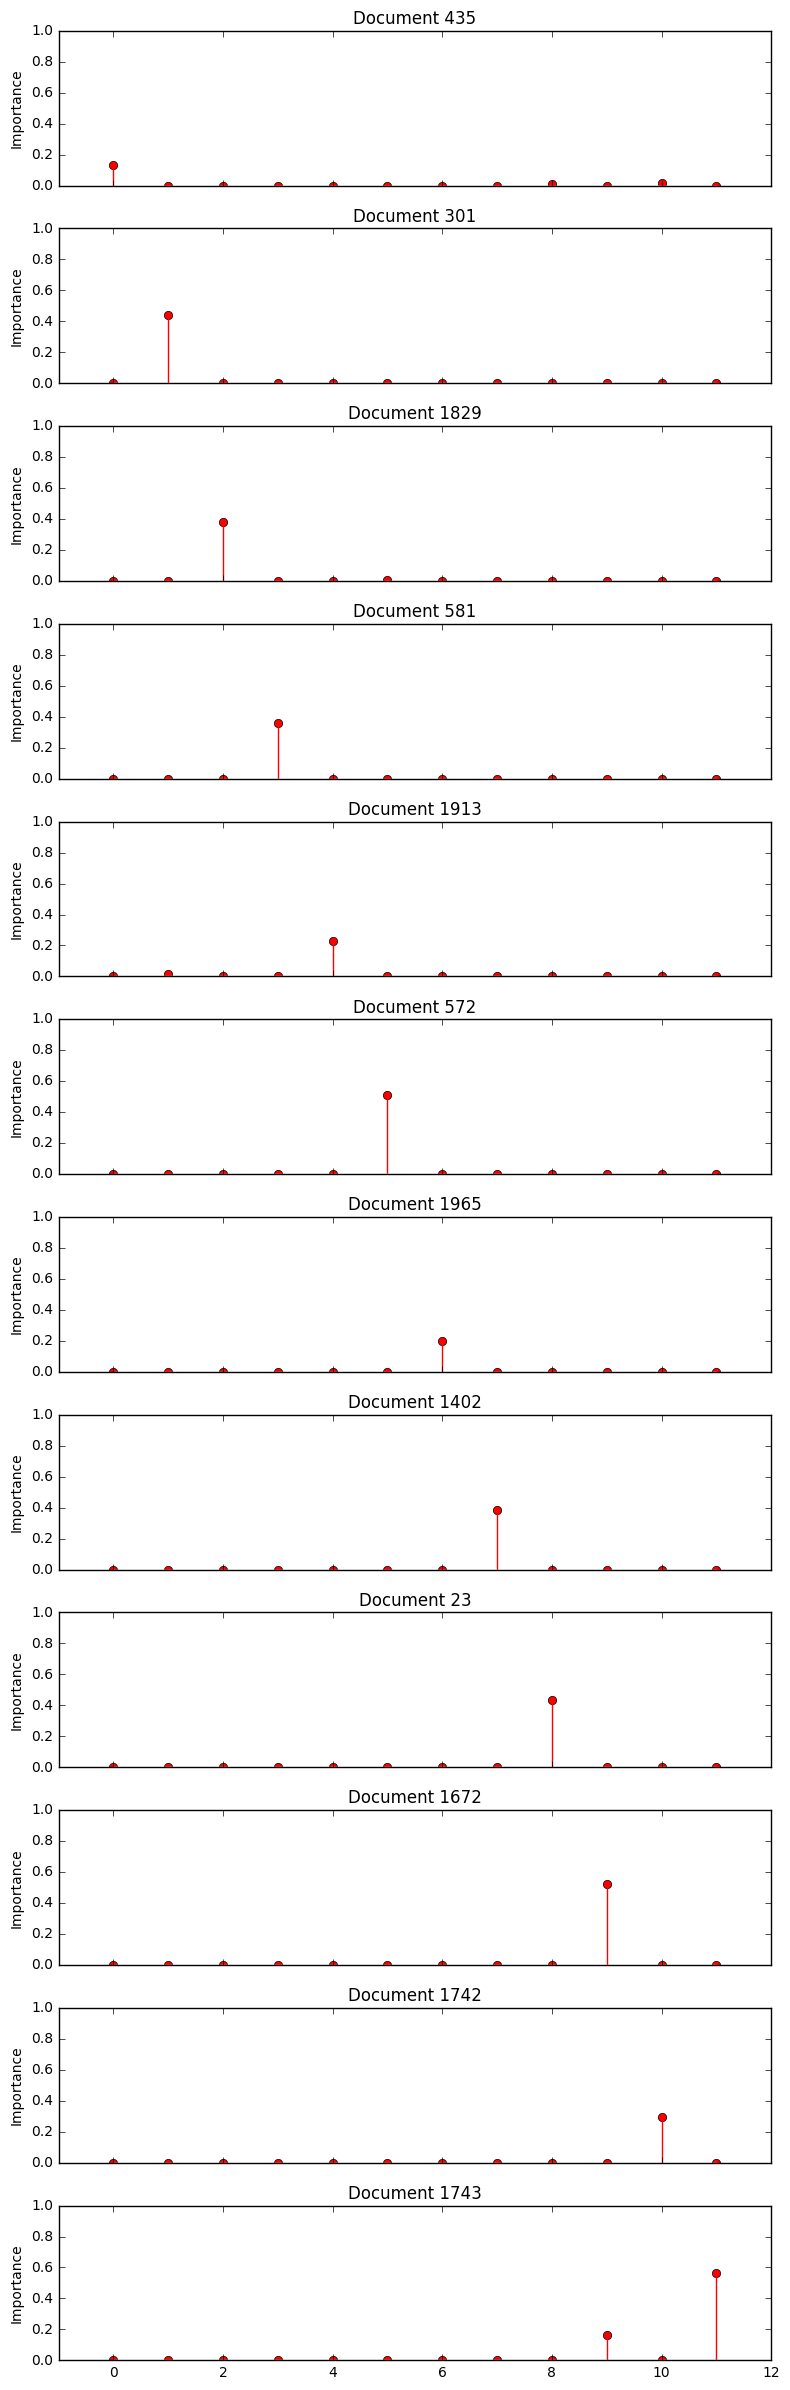

In [29]:
plot_doc_prob(best_nmf_hosts, nmf_doc_topic)

#### Visualizations for presenting

In [30]:
import seaborn as sns
sns.set_style('white')

In [31]:
viz_topics = {0: 1, 1: 4}

In [34]:
def plot_for_viz(index, topic, topic_word, features):
    #print features[topic_word[index].argmax()[:3]]
    
    f, ax= plt.subplots(1, 1, figsize=(8, 2), sharex=True)
    x_min = -10
    x_max = len(topic_word[0])+10
    y_min = 0
    y_max = round(max(topic_word[index])*1.1, 1)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    markerline, stemlines, baseline = ax.stem(topic_word[index]) #, linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(markerline, 'color', '#595959')
    plt.setp(stemlines, 'color', '#595959')
    plt.setp(baseline, 'color', '#595959')
    
    plt.tight_layout()
    plt.show()

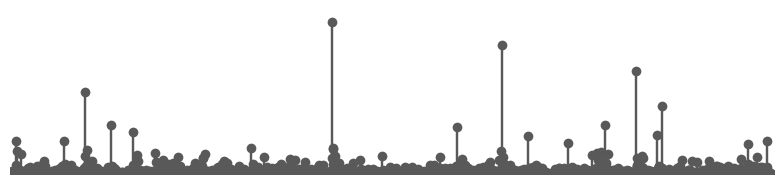

In [35]:
plot_for_viz(4, 'outdoorsy', nmf_topic_word, nmf_features)

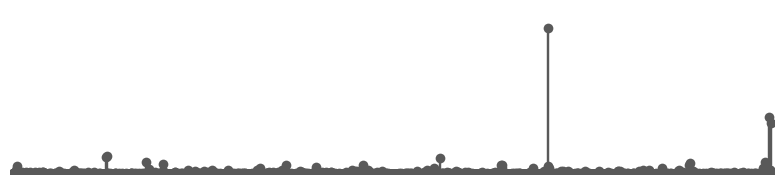

In [36]:
plot_for_viz(1, 'professional', nmf_topic_word, nmf_features)

#### Assign topic distribution to each listing

In [37]:
nmf_topics = pd.DataFrame(nmf_doc_topic, columns=nmf_topics)

In [38]:
nmf_topics = nmf_topics.merge(s_listings[['abouts', 'latitude', 'longitude']], left_index=True, right_index=True)

In [39]:
#create geojson of topic distributions for visualization on web map
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

In [40]:
columns = nmf_topics.columns.tolist()
columns += ['abouts']
geojson = df_to_geojson(nmf_topics, columns)

In [41]:
output_filename='../viz/nmf_topics.json'
with open(output_filename, 'wb') as output_file:
    json.dump(geojson, output_file, indent=2)

In [42]:
nmf_topics.to_csv('../viz/nmf_topics.csv', encoding='utf-8')

#### Pickle nmf topics dataframe

In [43]:
with open('../data/interim/nmf_topics.pkl', 'wb') as picklefile:
    pickle.dump(nmf_topics, picklefile)

### LDA (sklearn)

#### Create term frequency vector using host descriptions (stopwords removed)

In [27]:
# Create a CountVectorizer for parsing/counting words
lda_vectorizer = CountVectorizer(ngram_range=(1,2),
                                 min_df=3,
                                 token_pattern="\\b[a-z][a-z]+\\b")
counts = lda_vectorizer.fit_transform(lemmas)
lda_features = lda_vectorizer.get_feature_names()
len(lda_features)

74377

#### Extract topics using LDA on counts vector of host descriptions
* Number of components set to number of topics
* Learning method set to online for better performance

In [28]:
lda = LatentDirichletAllocation(n_topics=num_topics,
                                learning_method='online',
                                random_state=16)
lda_doc_topic = lda.fit_transform(counts)

In [29]:
lda_topic_word = lda.components_

In [30]:
best_lda_hosts = display_topics(lda, lda_doc_topic, lda_features, num_top_words)

Topic 0:
TOP 10 WORDS:
chula
minute tijuana
tijuana border
safe accord
walmart restaurant
top safe
restaurant trolley
crime statistic
bank hospital
historical cultural
REPRESENTATIVE HOST:
neighborhood    Northwest
city             sandiego
state                  CA
Name: 1073, dtype: object

Topic 1:
TOP 10 WORDS:
restaurant
bar
shop
away
minute
coffee
food
close
locate
distance
REPRESENTATIVE HOST:
neighborhood       Rosedale
city            newyorkcity
state                    NY
Name: 1312, dtype: object

Topic 2:
TOP 10 WORDS:
mi
eastern
common
charles
boston
national
newbury
public
copley
prudential
REPRESENTATIVE HOST:
neighborhood    Chinatown
city               boston
state                  MA
Name: 249, dtype: object

Topic 3:
TOP 10 WORDS:
restaurant
bar
minute
away
shop
distance
locate
store
close
apartment
REPRESENTATIVE HOST:
neighborhood     Hollywood
city            losangeles
state                   CA
Name: 689, dtype: object

Topic 4:
TOP 10 WORDS:
short entertainmen

In [48]:
lda_topics = ['local guide', 'retired w/hobbies', 'hippies', 'queen anne', \
             'topic 4', 'capitol hill', 'topic 6', 'from LA', 'laid back', \
              'outdoorsy', 'professional', 'real estate']

In [49]:
lda_topic_word_norm = lda_topic_word/np.sum(lda_topic_word, axis=1, keepdims=True)

In [50]:
round(max(lda_topic_word.flatten())*1.1, -1)

350.0

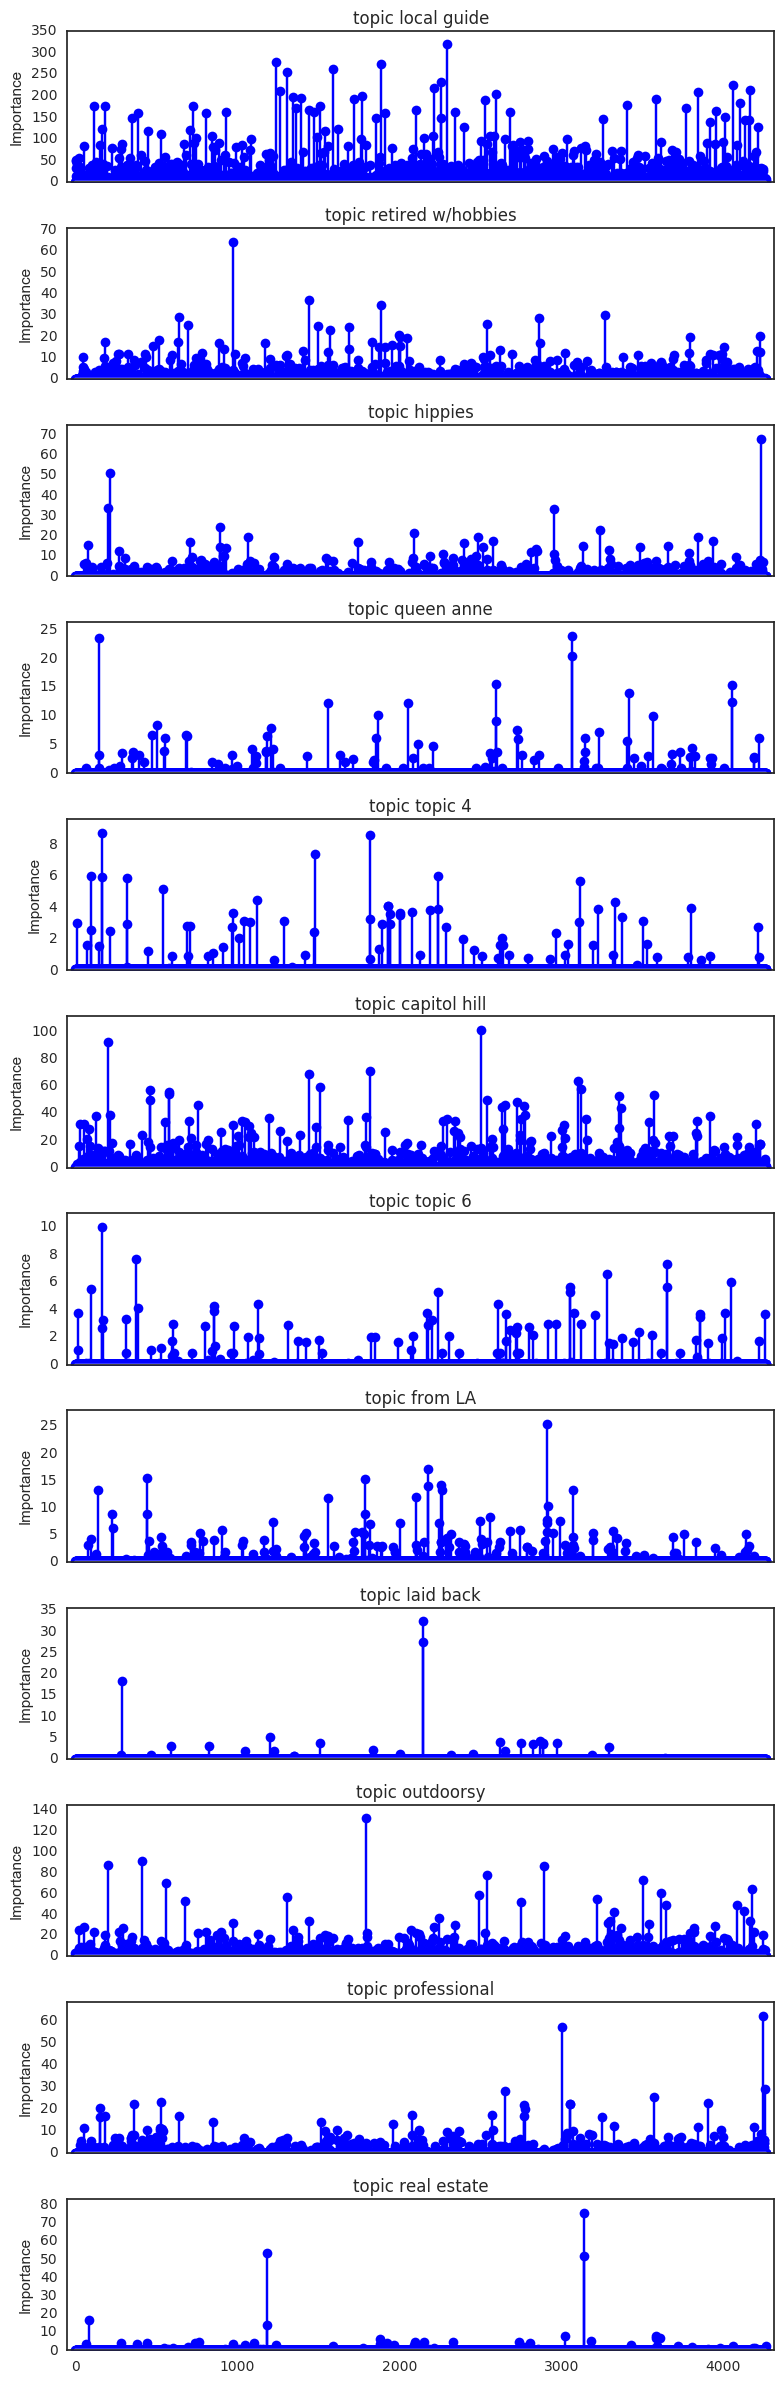

In [51]:
plot_word_prob(lda_topics, lda_topic_word)

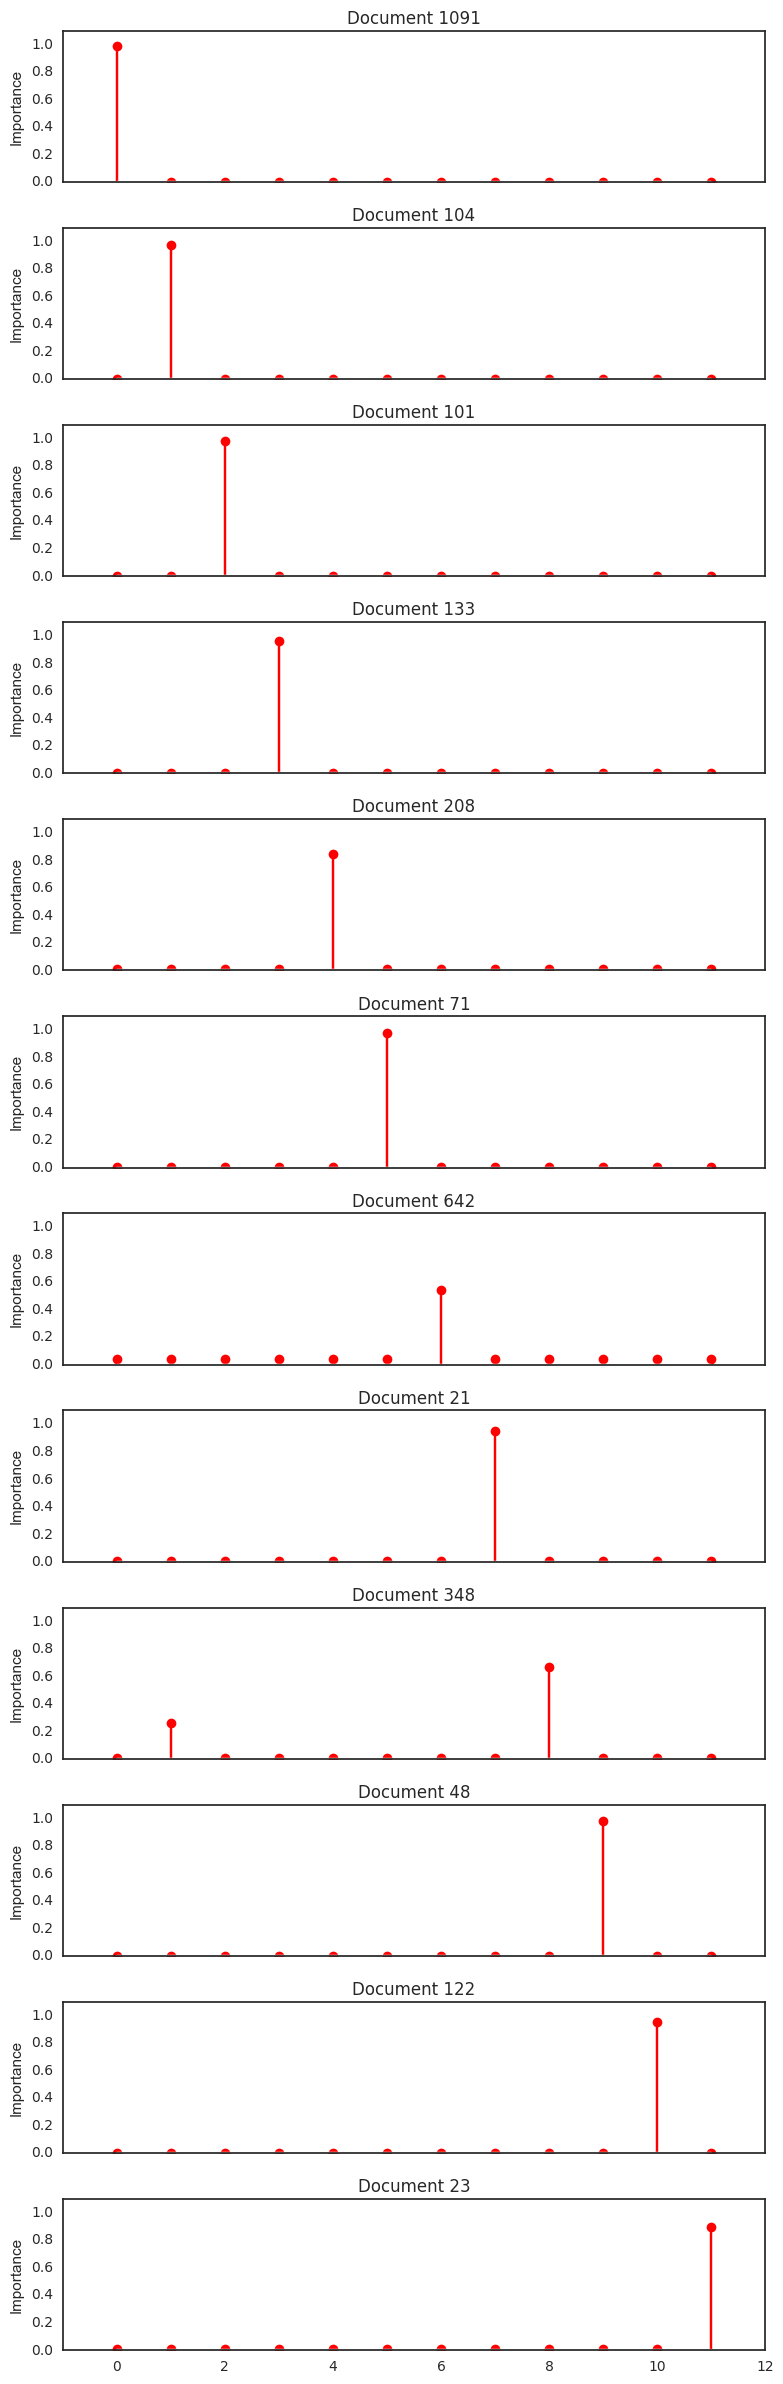

In [52]:
plot_doc_prob(best_lda_hosts, lda_doc_topic)

In [53]:
test_host = ['east coast']

In [54]:
test_host_vec = lda_vectorizer.transform(test_host)

In [55]:
np.argmax(lda.transform(test_host_vec)[0])

5

In [56]:
test_host_vec

<1x4262 sparse matrix of type '<type 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

#### Visualizations for presenting

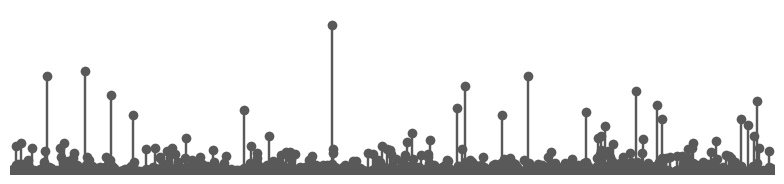

In [57]:
plot_for_viz(9, 'outdoorsy', lda_topic_word, lda_features)

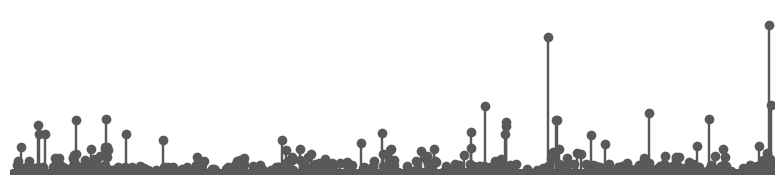

In [58]:
plot_for_viz(10, 'professional', lda_topic_word, lda_features)

#### Assign topic distribution to each listing

In [59]:
lda_topics = pd.DataFrame(lda_doc_topic, columns=lda_topics)

In [60]:
lda_topics.head()

,local guide,retired w/hobbies,hippies,queen anne,topic 4,capitol hill,topic 6,from LA,laid back,outdoorsy,professional,real estate
0,0.466423,0.002688,0.002688,0.002688,0.312379,0.002688,0.002688,0.002688,0.002688,0.002688,0.197004,0.002688
1,0.491339,0.009259,0.009259,0.009259,0.009259,0.416068,0.009259,0.009259,0.009259,0.009260,0.009259,0.009259
2,0.002033,0.002033,0.002033,0.002033,0.002033,0.002033,0.002033,0.002033,0.002033,0.977642,0.002033,0.002033
3,0.413297,0.003205,0.003205,0.157018,0.003205,0.003205,0.003205,0.003205,0.003205,0.003205,0.003205,0.400839
4,0.474959,0.003333,0.207073,0.003333,0.003333,0.287968,0.003333,0.003333,0.003333,0.003334,0.003333,0.003333


#### Pickle lda topics dataframe

In [61]:
with open('../data/interim/lda_topics.pkl', 'wb') as picklefile:
    pickle.dump(lda_topics, picklefile)

### gensim LDA

In [62]:
# Create the term-document matrix
# Transpose it so the terms are the rows
gensim_counts = tfidf.transpose()

In [63]:
gensim_counts.shape

(4262, 2011)

##### Convert to gensim
We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [64]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(gensim_counts)

In [65]:
id2word = dict((v, k) for k, v in lda_vectorizer.vocabulary_.items())

At this point we can simply plow ahead in creating an LDA model.  It requires our corpus of word counts, mapping of row ids to words, and the number of topics.

In [66]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=10)

Let's take a look at what happened.  Here are the 5 most important words for each of the topics we found:

In [67]:
lda.print_topics()

[(0,
  u'0.015*"look forward" + 0.014*"forward" + 0.014*"look" + 0.013*"anything" + 0.013*"ask" + 0.013*"leave" + 0.013*"hike" + 0.012*"west coast" + 0.012*"whole" + 0.011*"adventure"'),
 (1,
  u'0.051*"equal" + 0.047*"beauty pacific" + 0.040*"boston" + 0.039*"end" + 0.035*"beauty" + 0.030*"last" + 0.030*"pacific northwest" + 0.029*"northwest" + 0.029*"pacific" + 0.028*"little"'),
 (2,
  u'0.032*"tea" + 0.031*"mt rainy" + 0.027*"rainy" + 0.020*"northwesterner" + 0.020*"holland" + 0.020*"find" + 0.020*"husband house" + 0.019*"blend" + 0.019*"house" + 0.017*"black"'),
 (3,
  u'0.069*"inn" + 0.039*"back hand" + 0.039*"passionate traveler" + 0.037*"pantry" + 0.036*"romantic" + 0.035*"attention detail" + 0.033*"attention" + 0.003*"puget sound" + 0.003*"puget" + 0.002*"sound"'),
 (4,
  u'0.004*"software" + 0.004*"change" + 0.003*"responsible" + 0.003*"software engineer" + 0.003*"locate" + 0.003*"engineer" + 0.003*"california" + 0.003*"retire" + 0.003*"graphic designer" + 0.003*"graphic"'),
 

#### Topic Space
If we want to map our documents to the topic space we need to actually use the LdaModel transformer that we created above, like so:

In [68]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]
lda_corpus

In [69]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [70]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[245]

[(0, 0.14850188218558397),
 (1, 0.013531646515894407),
 (2, 0.013540940314604701),
 (3, 0.013530646366654074),
 (4, 0.013541836173193848),
 (5, 0.089998275118744919),
 (6, 0.013530820919118804),
 (7, 0.01353174035381151),
 (8, 0.52172141587714904),
 (9, 0.013530643435151594),
 (10, 0.013530643778825575),
 (11, 0.1315095089612677)]

In [71]:
s_listings['abouts'].iloc[245]

u"i've been a seattle resident for 40+ years and have owned my home for 35 years.  my spouse and i also have a houseboat on lake union and we have been lucky enough to have traveled to many wonderful places in the world.  our last major trip took us to province and eastern europe. our next will take us across canada by rail.  we love meeting and developing new friendships.  i hope you will enjoy my beautiful city and my sweet retro accommodations.  "

### pyLDAvis

In [72]:
pyLDAvis.enable_notebook()

In [73]:
tf_vectorizer = CountVectorizer(ngram_range=(1,2),
                                 min_df=5,
                                 token_pattern="\\b[a-z][a-z]+\\b")
dtm_tf = tf_vectorizer.fit_transform(host_lemmas)
print dtm_tf.shape

(2011, 2317)


In [74]:
lda_tf = LatentDirichletAllocation(n_topics=12, random_state=0)
lda_tf.fit(dtm_tf)

/Users/evaward/anaconda/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_jobs=1, n_topics=12, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [75]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      41.848459        1       1  0.118305  0.017048
3      15.579547        1       2  0.123139  0.010385
0      13.667583        1       3  0.191630 -0.025996
7      12.447404        1       4  0.185323  0.032099
9       6.050786        1       5  0.057976 -0.005151
5       4.059957        1       6  0.028705 -0.210318
10      2.273785        1       7 -0.195731 -0.249493
4       1.368859        1       8 -0.140246  0.143345
6       0.857306        1       9 -0.086440  0.100624
1       0.783080        1      10 -0.106459  0.081345
2       0.705363        1      11 -0.109513  0.051897
11      0.357870        1      12 -0.066688  0.054215, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
1364  Default  194.000000                move  194.000000  30.0000  30.0000
681   Default  239.000000             explore  239.000000  29.0000  29.0000
794   Default  296.000000                food  296.000000  28.0000  28.0000
1713  Default  110.000000            recently  110.000000  27.0000  27.0000
1004  Default  106.000000                hill  106.000000  26.0000  26.0000
268   Default  155.000000            business  155.000000  25.0000  25.0000
1646  Default   72.000000            property   72.000000  24.0000  24.0000
1383  Default  240.000000               music  240.000000  23.0000  23.0000
1688  Default  108.000000               raise  108.000000  22.0000  22.0000
1704  Default   72.000000                real   72.000000  21.0000  21.0000
815   Default  166.000000             forward  166.000000  20.0000  20.0000
1822  Default   77.000000                 san   77.000000  19.0000  19.0000
1233  Default  247.000000                look  247.000000  18.0000  18.0000
1234  Default  153.000000        look forward  153.000000  17.0000  17.0000
1573  Default  146.000000                play  146.000000  16.0000  16.0000
296   Default   73.000000             capitol   73.000000  15.0000  15.0000
2004  Default   72.000000               still   72.000000  14.0000  14.0000
297   Default   71.000000        capitol hill   71.000000  13.0000  13.0000
393   Default  107.000000             company  107.000000  12.0000  12.0000
1635  Default  159.000000        professional  159.000000  11.0000  11.0000
2092  Default  239.000000               thing  239.000000  10.0000  10.0000
1123  Default   59.000000                 job   59.000000   9.0000   9.0000
637   Default   50.000000              estate   50.000000   8.0000   8.0000
1969  Default  166.000000               spend  166.000000   7.0000   7.0000
233   Default   55.000000                born   55.000000   6.0000   6.0000
1705  Default   48.000000         real estate   48.000000   5.0000   5.0000
1650  Default  104.000000             provide  104.000000   4.0000   4.0000
1494  Default  162.000000            outdoors  162.000000   3.0000   3.0000
1673  Default   75.000000               quiet   75.000000   2.0000   2.0000
989   Default  249.000000                hike  249.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
1085  Topic12    0.069869             inquiry    5.140224   1.3345  -7.9333
1900  Topic12    0.069850           sit still    5.144987   1.3333  -7.9336
500   Topic12    0.069853          decide try    5.145496   1.3333  -7.9336
1419  Topic12    0.069856         newly marry    5.157005   1.3311  -7.9335
584   Topic12    0.069854           eat local    5.157956   1.3309  -7.9335
1007  Topic12    0.069843             hip hop    5.167452   1.3289  -7.9337
1970  Topic12    0.069850           spend day    5.175981   1.3273  -7.9336
866   Topic12    0.110428                 gay    8.366635   1.3051  -7.4756
1370  Topic12    0.070847               moved    5.282515   1.3211  -7.9194
1464  Top